In [1]:
import locale
from helpers import tools
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import seaborn as sns

pd.options.mode.copy_on_write = True

# Set locale to German
locale.setlocale(locale.LC_TIME, "de_DE.utf8")

# Apply the default theme
sns.set_theme()

def save_data():
    df = pd.DataFrame()

    for city in ["duesseldorf", "kiel", "dresden"]:
        city_df = tools.retrieveSlotData(city=city, concern=None)
        df = pd.concat([df, city_df])

    df.to_csv("db/data.csv")


# save_data()

df = tools.read_data_from_csv()

df["days_open"] = df["total_delta"].dt.total_seconds() / 3600 / 24

df["days_until_slot"] = df["time_until_slot"].dt.total_seconds() / 3600 / 24

In [26]:
# prevent exponential notation
pd.options.display.float_format = '{:.2f}'.format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599791 entries, 0 to 1599790
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype          
---  ------                --------------    -----          
 0   Unnamed: 0            1599791 non-null  int64          
 1   s_id                  1599791 non-null  int64          
 2   office                1599791 non-null  object         
 3   city                  1599791 non-null  object         
 4   timeslot              1599791 non-null  datetime64[ns] 
 5   concern               1599791 non-null  object         
 6   a_id                  1599791 non-null  int64          
 7   available             1599790 non-null  datetime64[ns] 
 8   taken                 1576325 non-null  datetime64[ns] 
 9   count_availabilities  1599791 non-null  int64          
 10  weekday               1599791 non-null  object         
 11  hour                  1599791 non-null  int64          
 12  delta                 157632

In [3]:
concerns = [
    "Personalausweis - Antrag",
    "Reisepass - Antrag",
    "Anmeldung",
    "Ummeldung",
    "Abmeldung",
]

# cities = ["Duesseldorf", "Dresden", "Kiel"]
# cities = ["Duesseldorf", "Dresden"]
cities = ["Duesseldorf"]

concern = "Personalausweis - Antrag"

filtered_df = df[
    (df["concern"] == concern)
    & (df["city"] == "Duesseldorf")
    # & (df["office"].isin(offices))
]

filtered_df.loc[:, "is_dz"] = filtered_df.loc[:, "office"] == "Dienstleistungszentrum"

without_dz = filtered_df[filtered_df["is_dz"] == False]

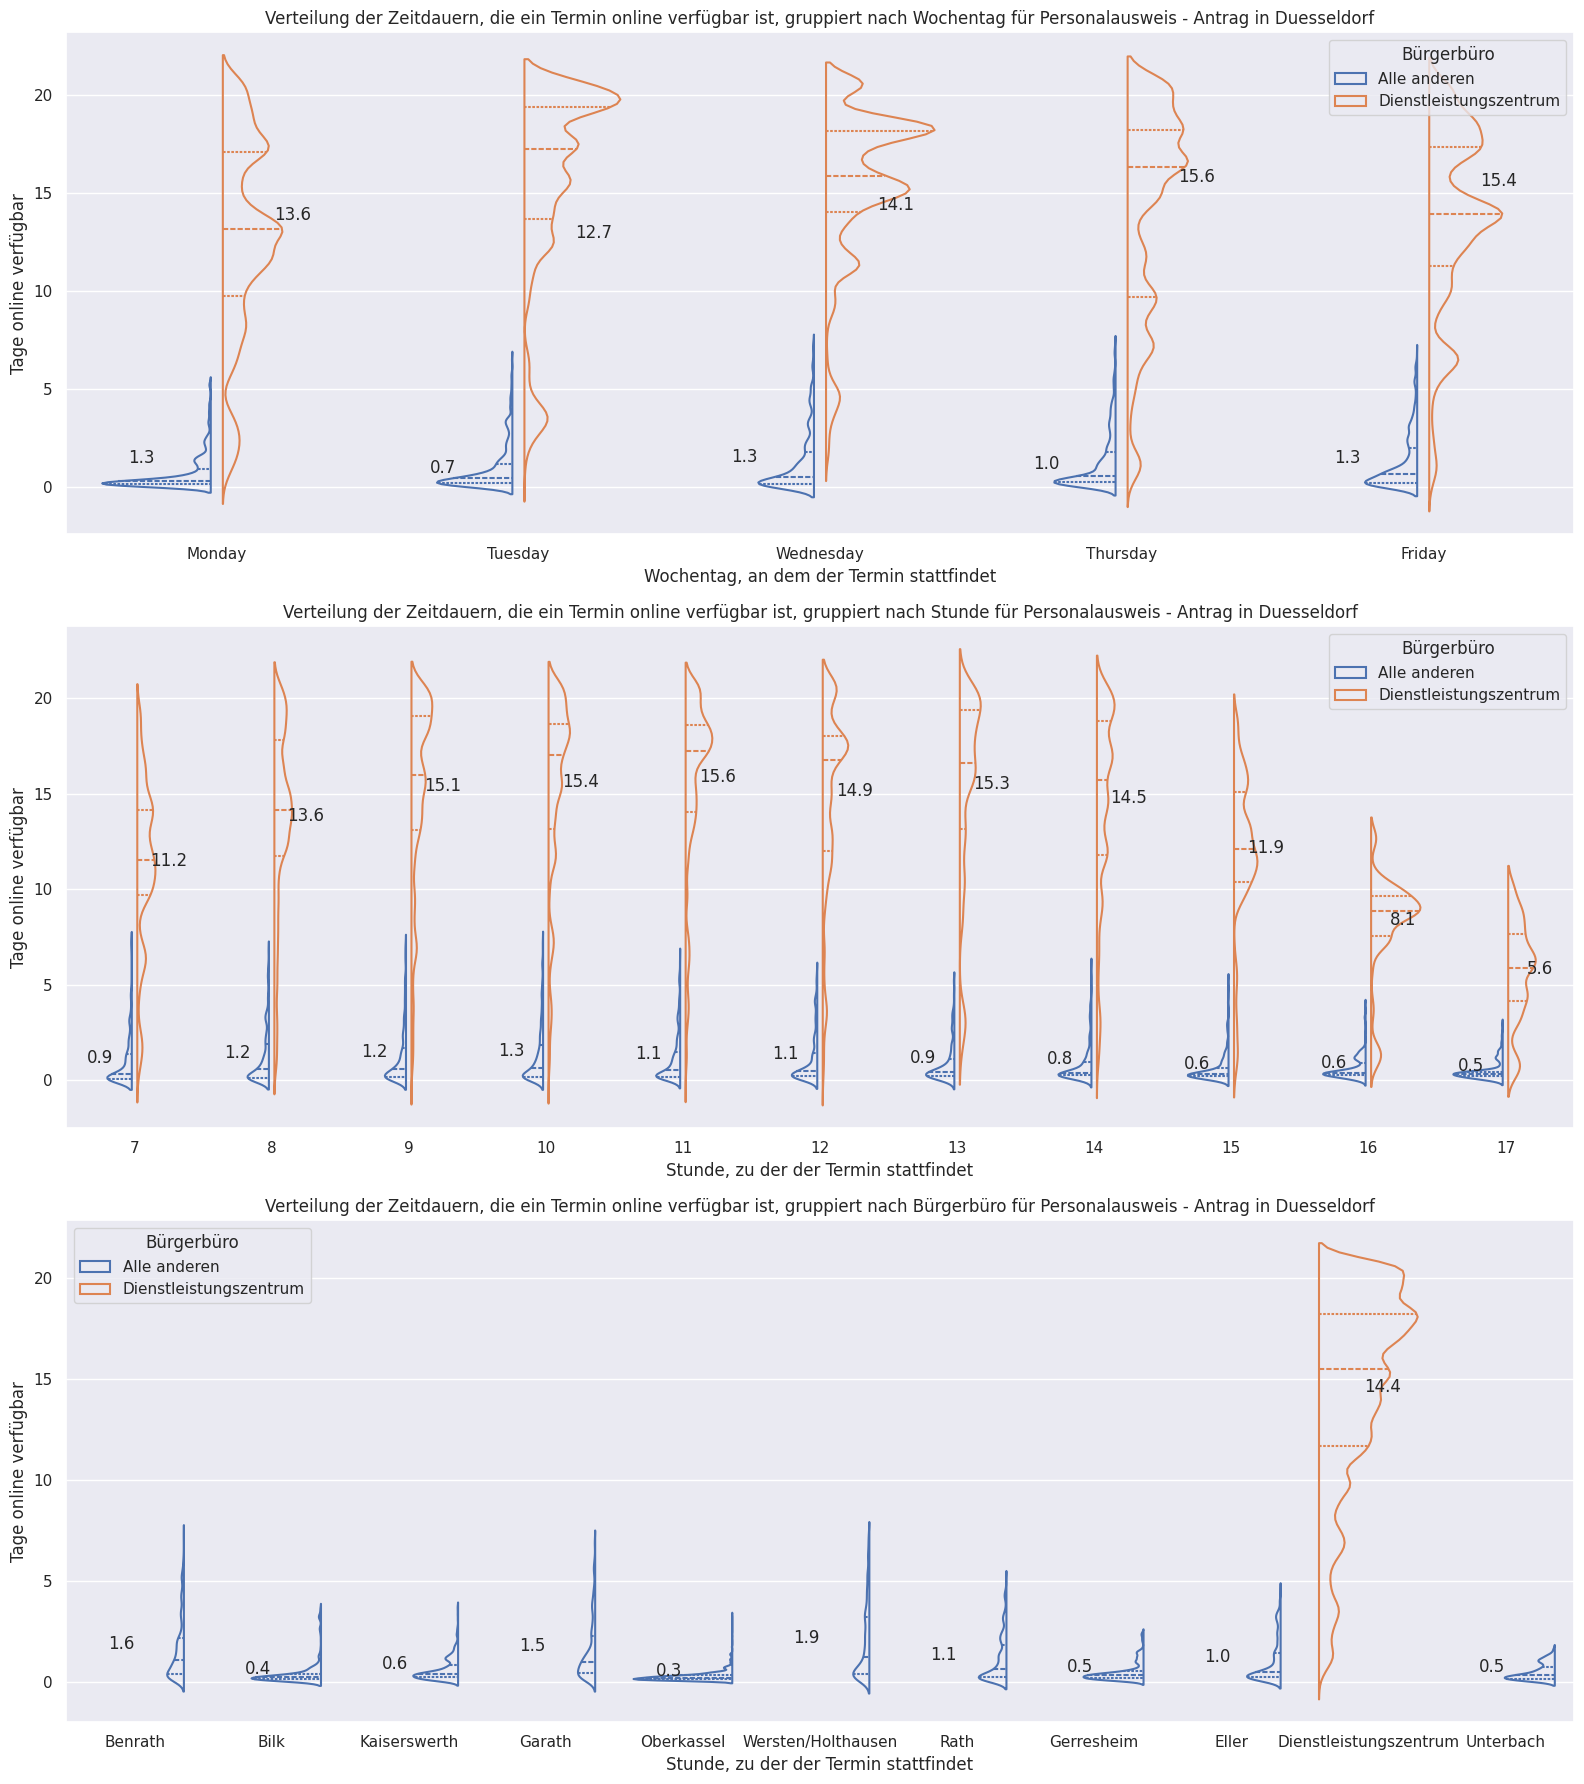

In [4]:
# categories = ["hour", "office"]
categories = ["weekday", "hour", "office"]
label = {"weekday": "Wochentag", "hour": "Stunde", "office": "Bürgerbüro"}

fig, ax = plt.subplots(
    figsize=(16, 6 * len(categories)), nrows=len(categories), ncols=1
)

for index, value_to_group_by in enumerate(categories):
    sns.violinplot(
        x=value_to_group_by,
        y="days_open",
        data=filtered_df,
        ax=ax[index],
        inner="quart",
        fill=False,
        hue="is_dz",
        split=True,
        gap=0.1,
        order=(
            [
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
            ]
            if value_to_group_by == "weekday"
            else None
        ),
    )

    if value_to_group_by == "office":
        for i, office in enumerate(filtered_df["office"].unique()):
            mean = (
                filtered_df.groupby(value_to_group_by)["days_open"].mean().loc[office]
            )
            ax[index].text(
                i + 0.1 if office == "Dienstleistungszentrum" else i - 0.1,
                mean,
                f"{mean:.1f}",
                # fontsize=12,
                # color="black",
                ha="center",
            )
    else:

        # text with mean value for each group in the violin plot at y = 10
        for i, group_name in enumerate(
            filtered_df.groupby(value_to_group_by)["days_open"].mean().index
        ):
            mean_dz = mean = (
                filtered_df[filtered_df["is_dz"] == True]
                .groupby(value_to_group_by)["days_open"]
                .mean()
                .loc[group_name]
            )
            mean_without_dz = mean = (
                filtered_df[filtered_df["is_dz"] == False]
                .groupby(value_to_group_by)["days_open"]
                .mean()
                .loc[group_name]
            )
            ax[index].text(
                i - 0.25,
                mean_without_dz,
                f"{mean_without_dz:.1f}",
                # fontsize=12,
                # color="black",
                ha="center",
            )

            ax[index].text(
                i + 0.25,
                mean_dz,
                f"{mean_dz:.1f}",
                # fontsize=12,
                # color="black",
                ha="center",
            )

    title = f"Verteilung der Zeitdauern, die ein Termin online verfügbar ist, gruppiert nach {label[value_to_group_by]} für {concern} in {' und '.join(cities)}"
    ax[index].set_title(title)
    ax[index].set_xlabel(
        f"{'Wochentag, an dem der Termin stattfindet' if value_to_group_by == 'weekday' else 'Stunde, zu der der Termin stattfindet'}"
    )
    ax[index].set_ylabel("Tage online verfügbar")
    ax[index].legend(
        title="Bürgerbüro",
        handles=ax[index].get_legend_handles_labels()[0],
        labels=["Alle anderen", "Dienstleistungszentrum"],
    )
    # ax[index].legend(
    #     title="Stadt", handles=ax[index].get_legend_handles_labels()[0], labels=cities
    # )
plt.tight_layout()

plt.savefig("./bachelorarbeit/bilder/violinplot_days_open.png", bbox_inches="tight")
plt.show()

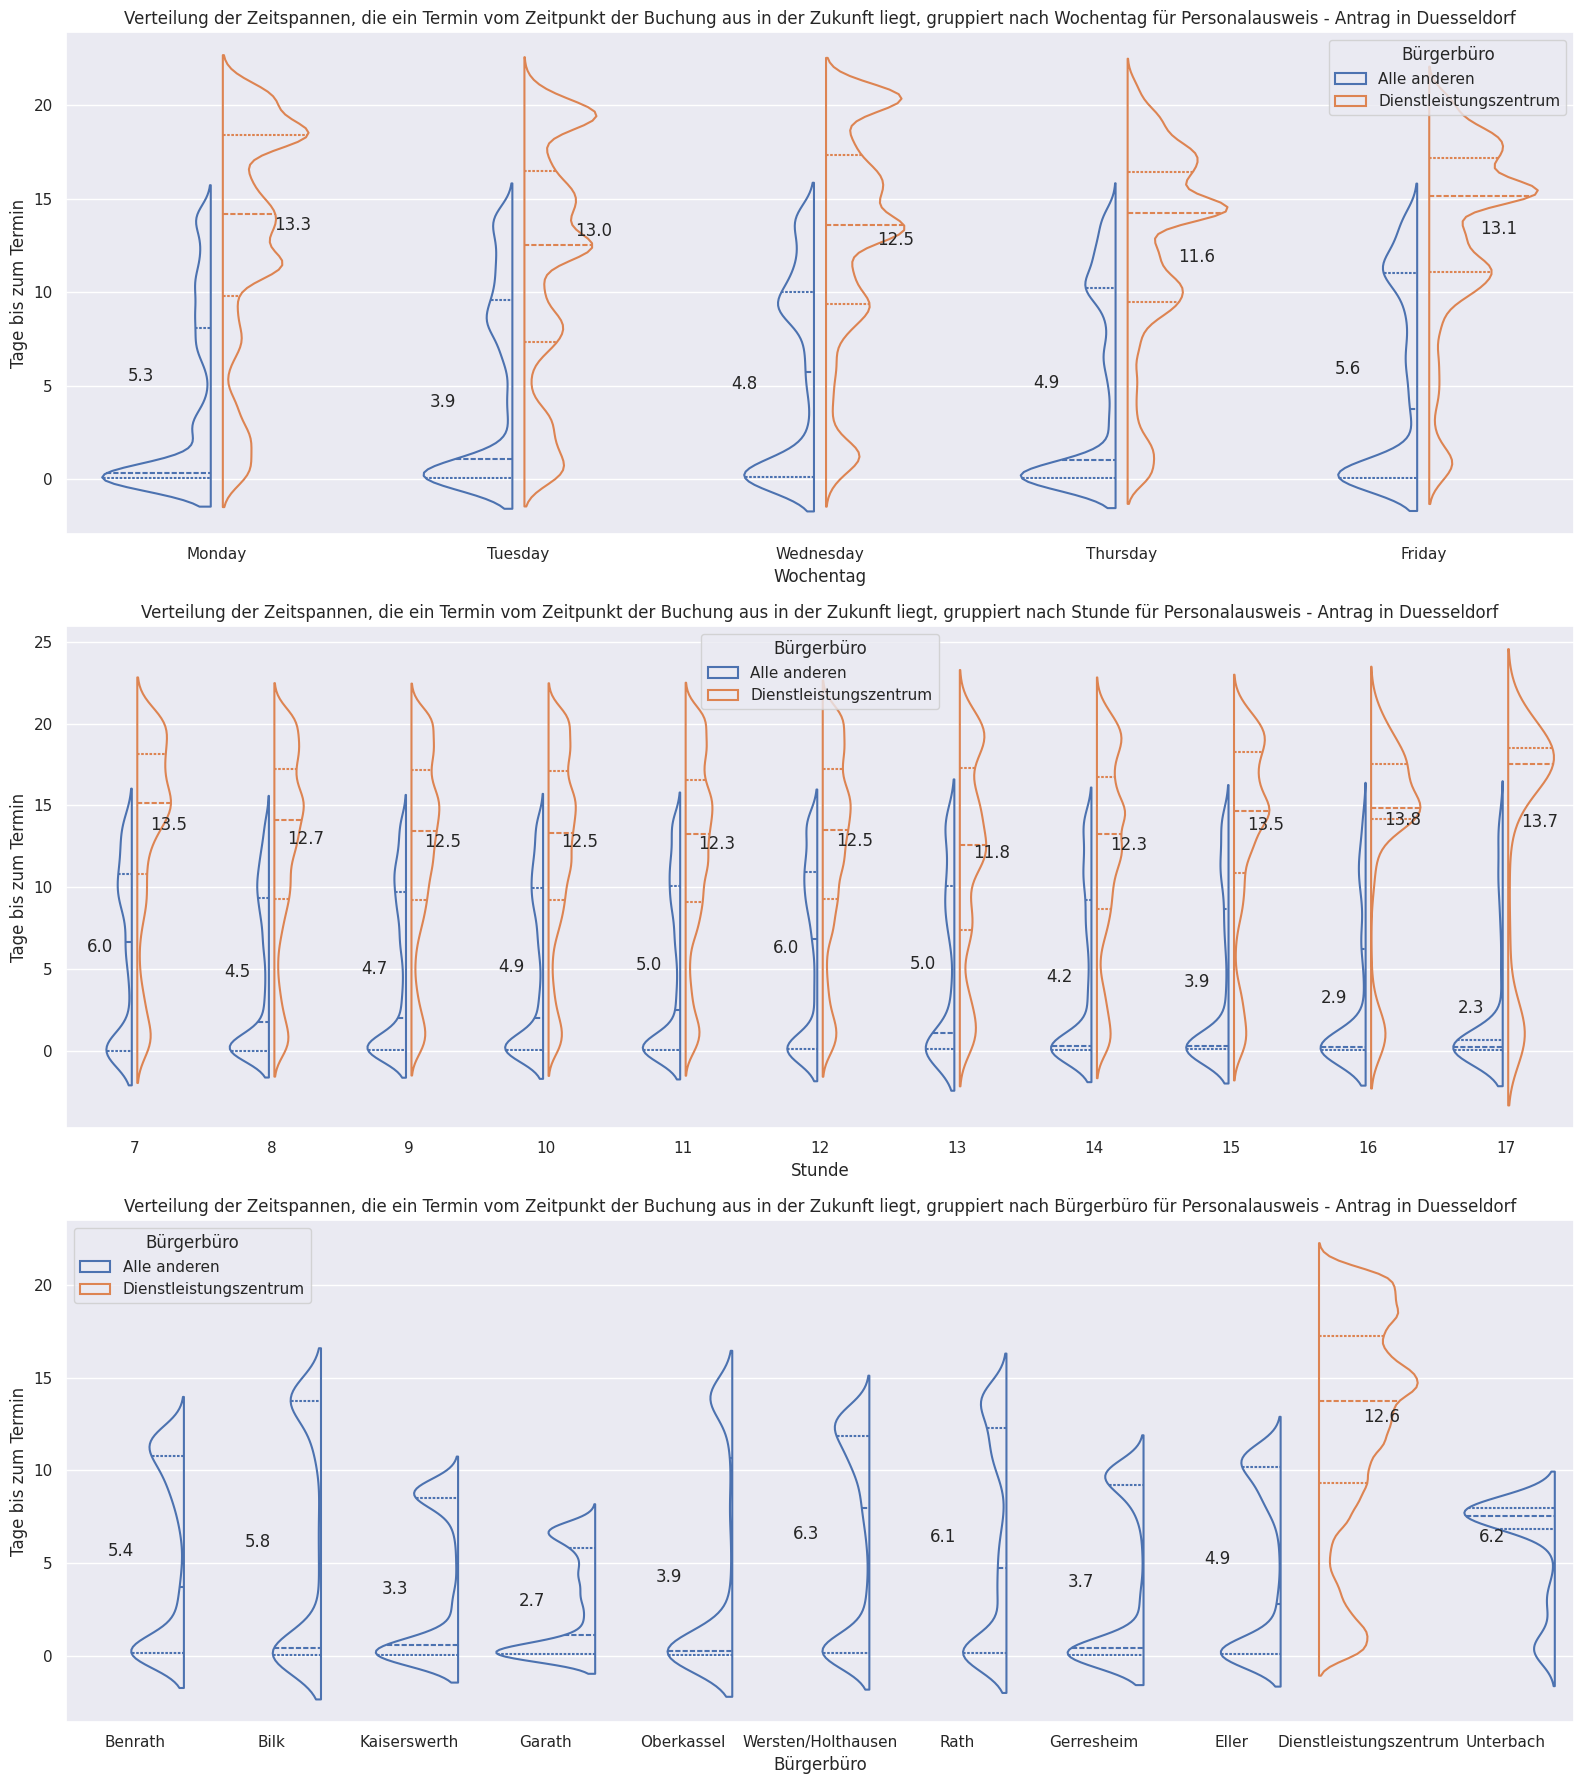

In [5]:
fig, ax = plt.subplots(
    figsize=(16, 6 * len(categories)), nrows=len(categories), ncols=1
)

for index, value_to_group_by in enumerate(categories):
    sns.violinplot(
        x=value_to_group_by,
        y="days_until_slot",
        data=filtered_df,
        ax=ax[index],
        inner="quart",
        fill=False,
        hue="is_dz",
        split=True,
        gap=0.1,
        order=(
            [
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
                # "Saturday",
            ]
            if value_to_group_by == "weekday"
            else None
        ),
    )

    if value_to_group_by == "office":
        for i, office in enumerate(filtered_df["office"].unique()):
            mean = (
                filtered_df.groupby(value_to_group_by)["days_until_slot"].mean().loc[office]
            )
            ax[index].text(
                i + 0.1 if office == "Dienstleistungszentrum" else i - 0.1,
                mean,
                f"{mean:.1f}",
                # fontsize=12,
                # color="black",
                ha="center",
            )
    else:

        # text with mean value for each group in the violin plot at y = 10
        for i, group_name in enumerate(
            filtered_df.groupby(value_to_group_by)["days_until_slot"].mean().index
        ):
            mean_dz = mean = (
                filtered_df[filtered_df["is_dz"] == True]
                .groupby(value_to_group_by)["days_until_slot"]
                .mean()
                .loc[group_name]
            )
            mean_without_dz = mean = (
                filtered_df[filtered_df["is_dz"] == False]
                .groupby(value_to_group_by)["days_until_slot"]
                .mean()
                .loc[group_name]
            )
            ax[index].text(
                i - 0.25,
                mean_without_dz,
                f"{mean_without_dz:.1f}",
                # fontsize=12,
                # color="black",
                ha="center",
            )

            ax[index].text(
                i + 0.25,
                mean_dz,
                f"{mean_dz:.1f}",
                # fontsize=12,
                # color="black",
                ha="center",
            )

    title = f"Verteilung der Zeitspannen, die ein Termin vom Zeitpunkt der Buchung aus in der Zukunft liegt, gruppiert nach {label[value_to_group_by]} für {concern} in {' und '.join(cities)}"
    ax[index].set_title(title)
    # ax[index].set_xlabel(
    #     f"{'Wochentag, an dem der Termin stattfindet' if value_to_group_by == 'weekday' else 'Stunde, zu der der Termin stattfindet'}"
    # )
    ax[index].set_xlabel(f"{label[value_to_group_by]}")
    ax[index].set_ylabel("Tage bis zum Termin")

    ax[index].legend(
        title="Bürgerbüro",
        handles=ax[index].get_legend_handles_labels()[0],
        labels=["Alle anderen", "Dienstleistungszentrum"],
    )

plt.tight_layout()

plt.savefig(
    "./bachelorarbeit/bilder/violinplot_days_until_slot.png", bbox_inches="tight"
)
plt.show()

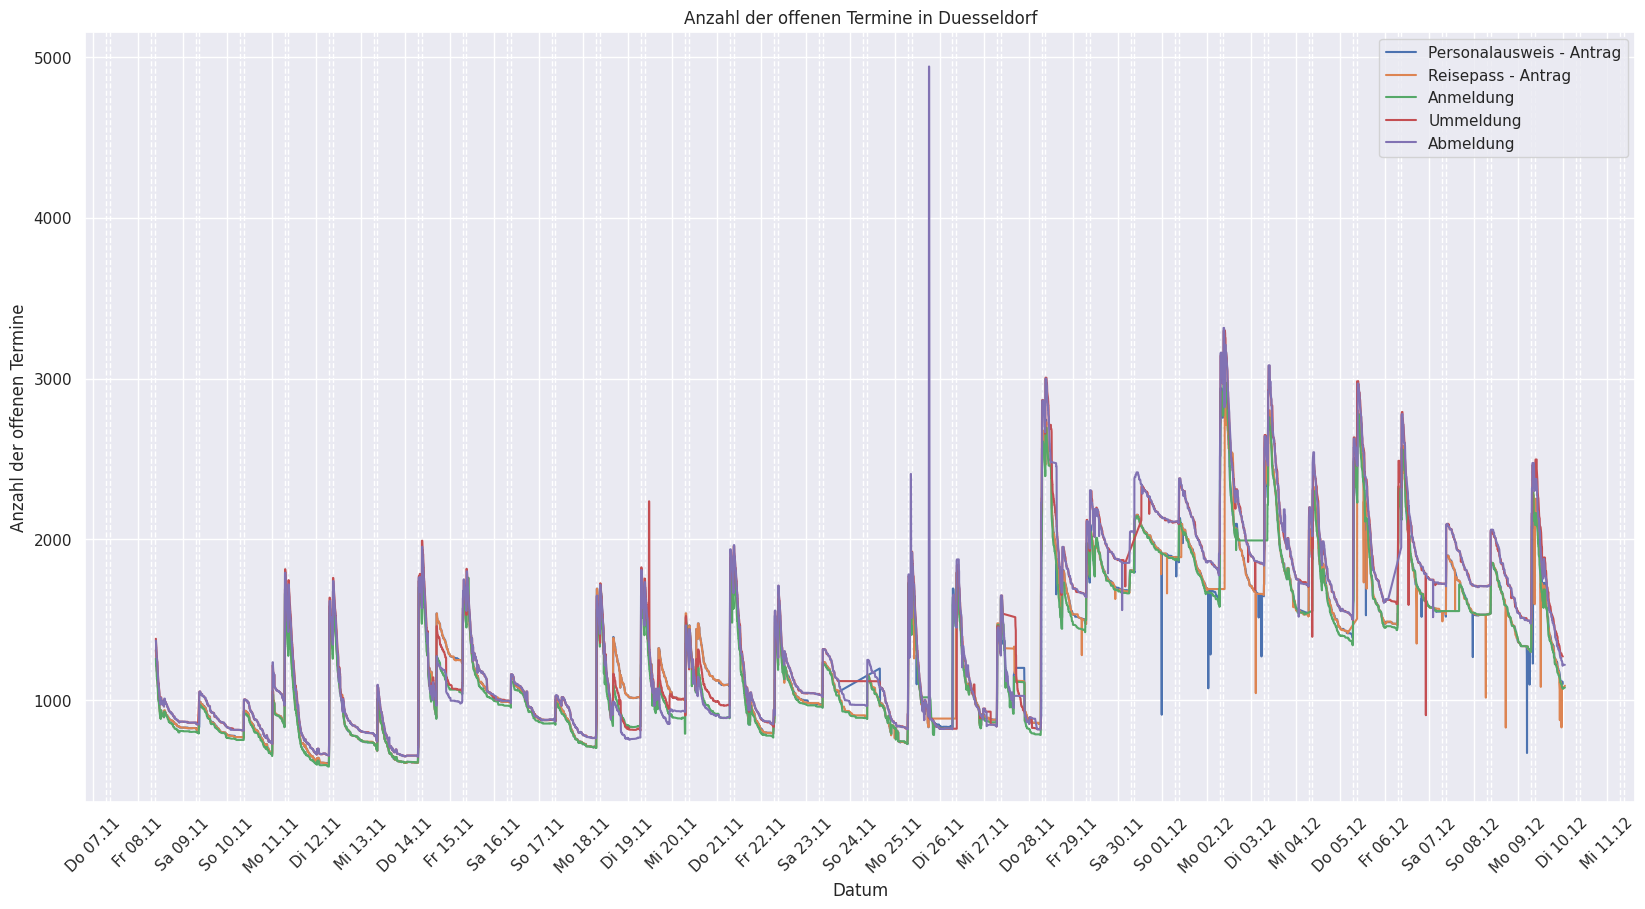

In [6]:
# duesseldorf all concerns
fig, ax = plt.subplots(figsize=(20, 10))



for concern in concerns:
    count = tools.create_time_series(
        df, city="Duesseldorf", concern=concern
    )
    count["concern"] = concern

    count["smooth"] = count["count"].rolling(window=7).max()

    # sns.lineplot(data=count, x="timestamp", y="count", ax=ax, label=concern)
    sns.lineplot(data=count, x="timestamp", y="smooth", ax=ax, label=concern)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
ax.xaxis.grid(True, which="minor", linestyle="--")

ax.set_title("Anzahl der offenen Termine in Duesseldorf")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl der offenen Termine")

plt.savefig(
    f"bachelorarbeit/bilder/offene_termine_duesseldorf_alle_anliegen.png",
)

plt.show()

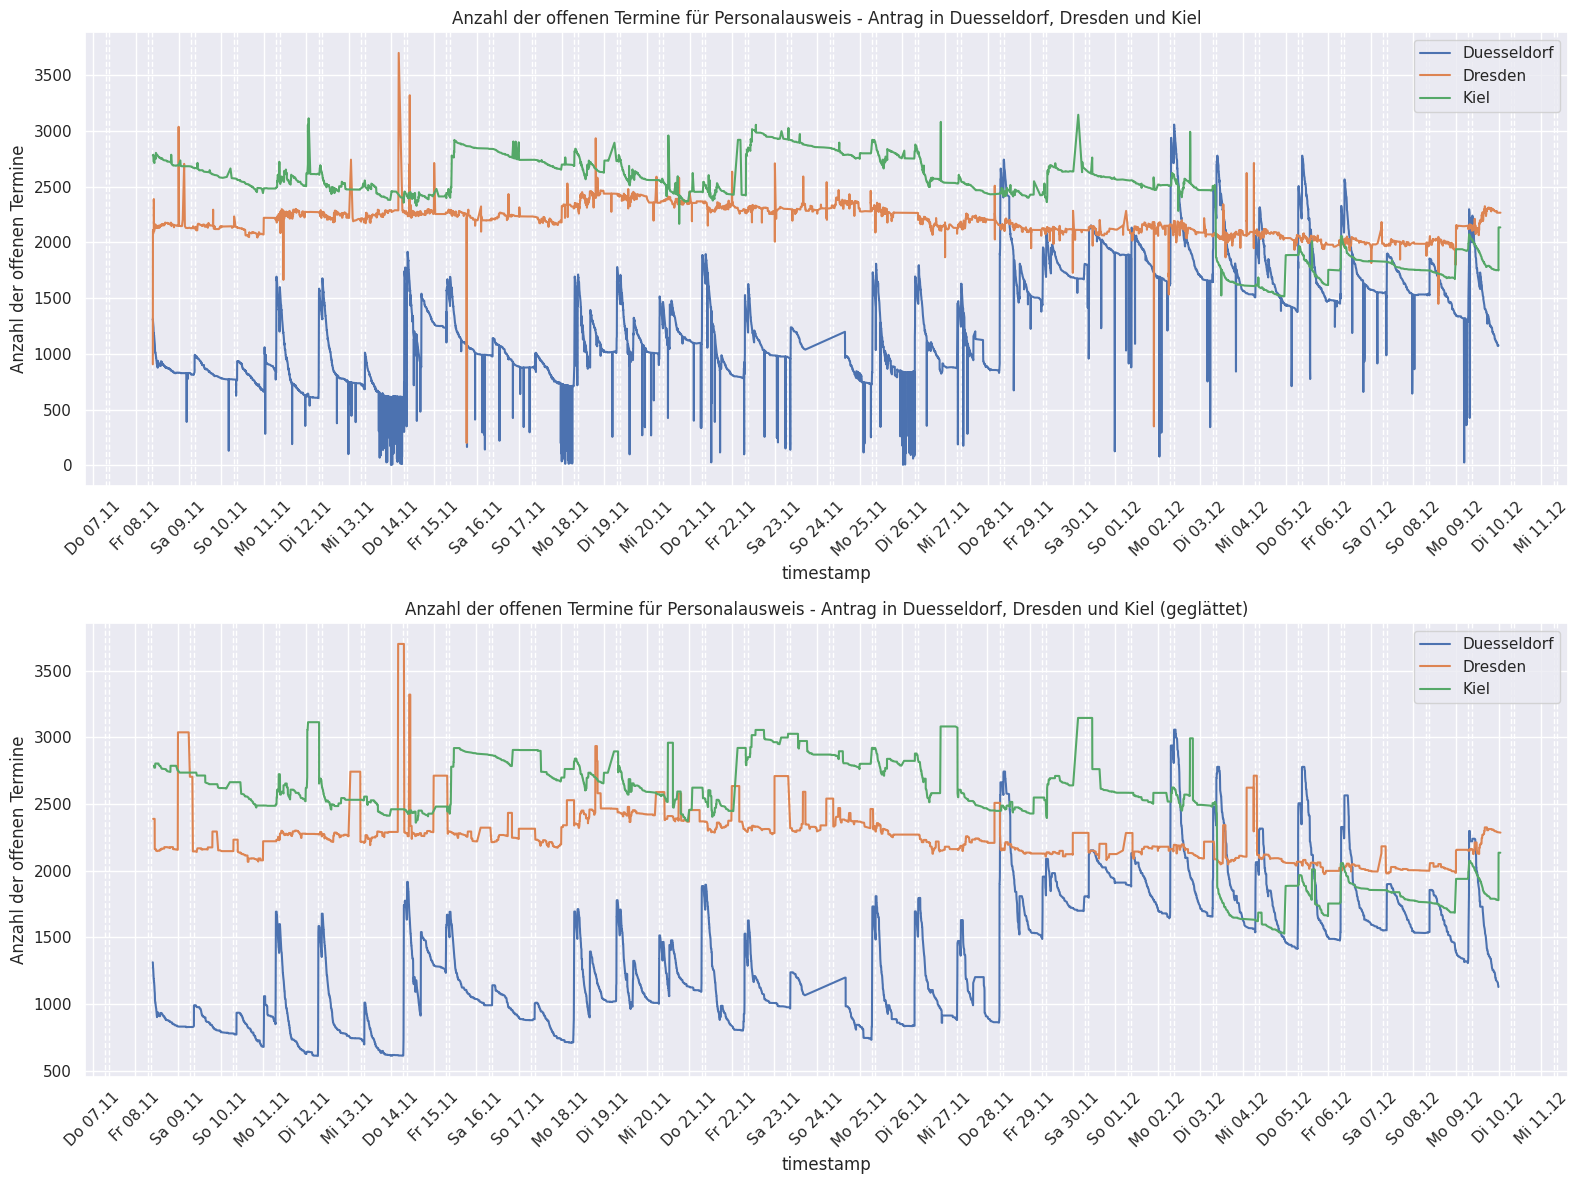

In [7]:
fig, axs = plt.subplots(figsize=(16, 12), nrows=2, ncols=1)

for index, variant in enumerate(["count", "smooth"]):
    for concern in ["Duesseldorf", "Dresden", "Kiel"]:
        count = tools.create_time_series(
            df, city=concern, concern="Personalausweis - Antrag"
        )

        # glättung durch maximum
        count["smooth"] = count["count"].rolling(window=15).max()
        sns.lineplot(data=count, x="timestamp", y=variant, ax=axs[index], label=concern)

    axs[index].xaxis.set_major_locator(mdates.DayLocator())
    axs[index].xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
    plt.setp(axs[index].xaxis.get_majorticklabels(), rotation=45)

    axs[index].xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
    axs[index].xaxis.grid(True, which="minor", linestyle="--")

    axs[index].set_title(
        f"Anzahl der offenen Termine für Personalausweis - Antrag in Duesseldorf, Dresden und Kiel"
        + (" (geglättet)" if variant == "smooth" else "")
    )
    # axs[index].set_xlabel("Datum")
    axs[index].set_ylabel("Anzahl der offenen Termine")

plt.tight_layout()

plt.savefig(
    f"bachelorarbeit/bilder/offene_termine_personalausweis_alle_staedte.png",
)
plt.show()

In [8]:
duesseldorf = df[(df["concern"] == "Personalausweis - Antrag") & (df["city"] == "Duesseldorf")]

# duesseldorf_smooth = duesseldorf[duesseldorf["delta"] > pd.Timedelta(15, unit="m")]

dues_ohne_dz = tools.create_time_series(
    duesseldorf,
    city="Duesseldorf",
    concern="Personalausweis - Antrag",
    exclude_office="Dienstleistungszentrum",
)

dues_nur_dz = tools.create_time_series(
    duesseldorf,
    city="Duesseldorf",
    concern="Personalausweis - Antrag",
    office="Dienstleistungszentrum",
)

# dues_nur_dz[dues_nur_dz["delta"] < pd.Timedelta(5, unit="m")]

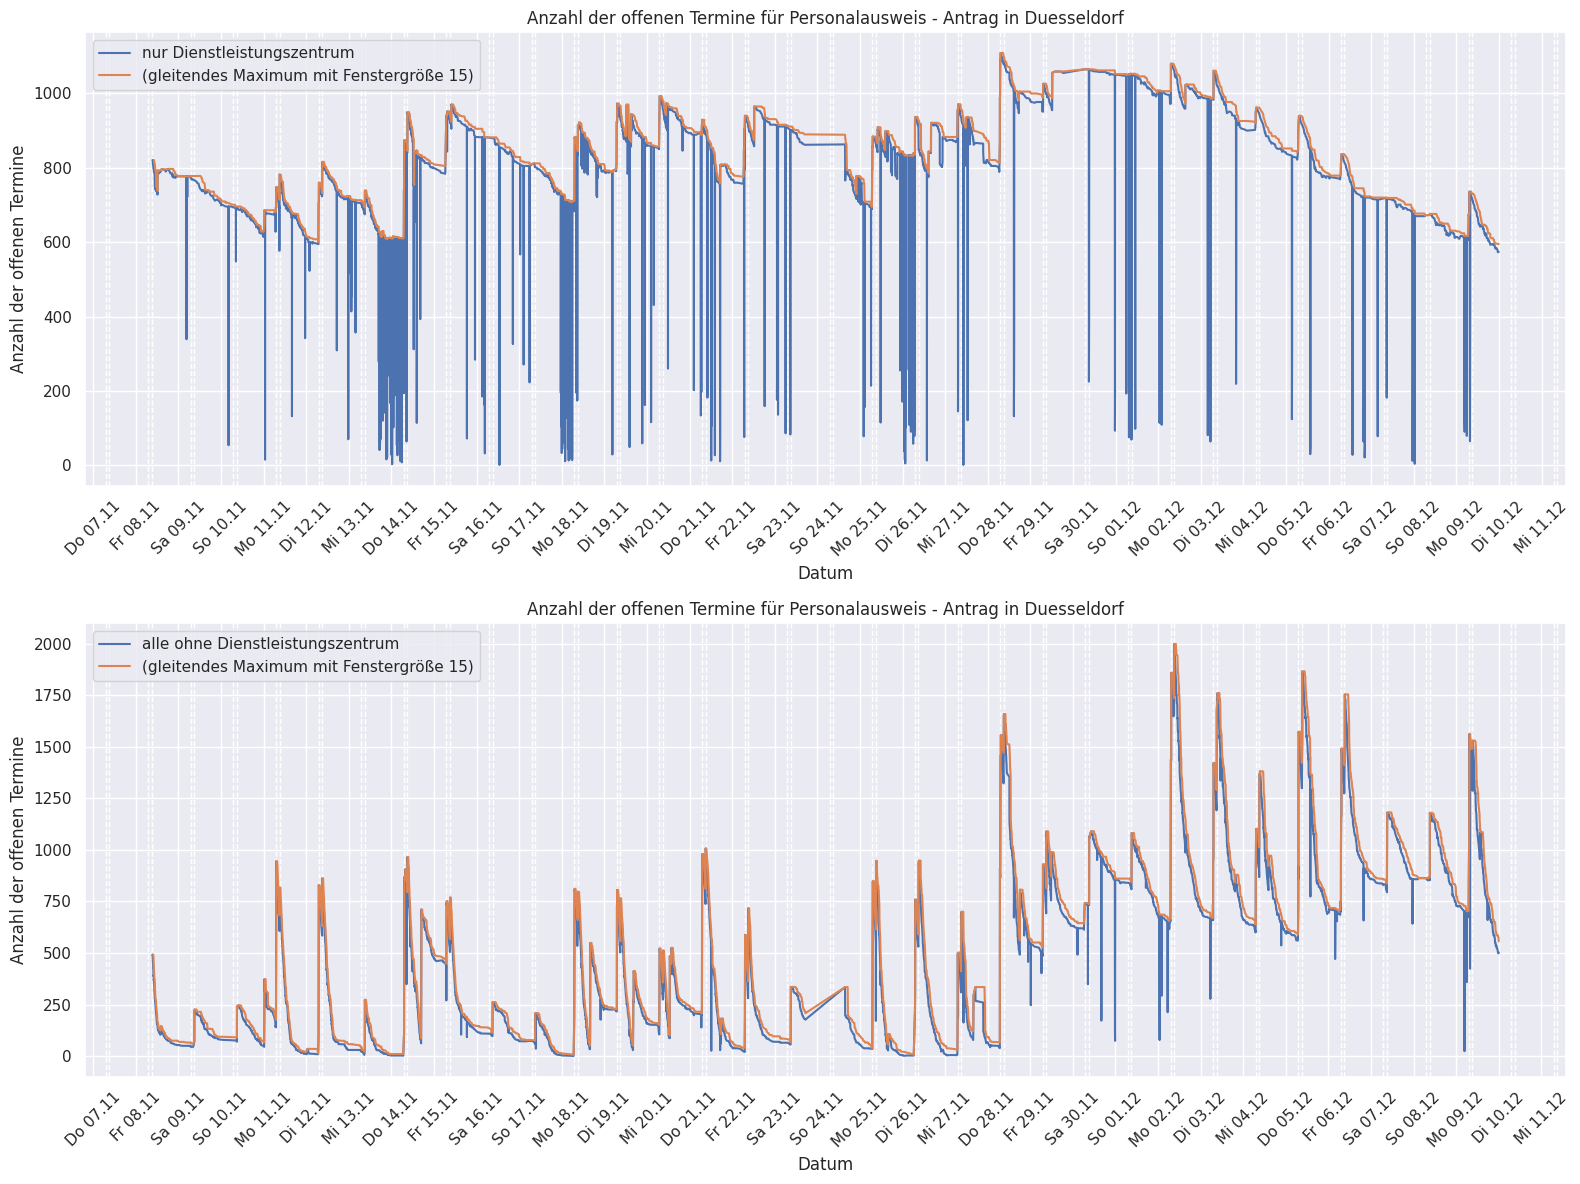

In [9]:
# duesseldorf ohne Dienstleistungszenrum
fig, axs = plt.subplots(figsize=(16, 12), nrows=2, ncols=1)

for index, data in enumerate([dues_nur_dz, dues_ohne_dz]):
    

    data["smooth"] = data["count"].rolling(window=15).max()

    sns.lineplot(
        data=data,
        x="timestamp",
        y="count",
        ax=axs[index],
        label=f"{'nur Dienstleistungszentrum' if index == 0 else 'alle ohne Dienstleistungszentrum'}",
    )

    sns.lineplot(
        data=data,
        x="timestamp",
        y="smooth",
        ax=axs[index],
        label=f"(gleitendes Maximum mit Fenstergröße 15)"
    )


    axs[index].xaxis.set_major_locator(mdates.DayLocator())
    axs[index].xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
    plt.setp(axs[index].xaxis.get_majorticklabels(), rotation=45)

    axs[index].xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
    axs[index].xaxis.grid(True, which="minor", linestyle="--")

    axs[index].set_title(
        "Anzahl der offenen Termine für Personalausweis - Antrag in Duesseldorf"
    )
    axs[index].set_xlabel("Datum")
    axs[index].set_ylabel("Anzahl der offenen Termine")

plt.tight_layout()
plt.savefig(
    f"bachelorarbeit/bilder/offene_termine_personalausweis_duesseldorf_mit_ohne_dz.png",
)
plt.show()

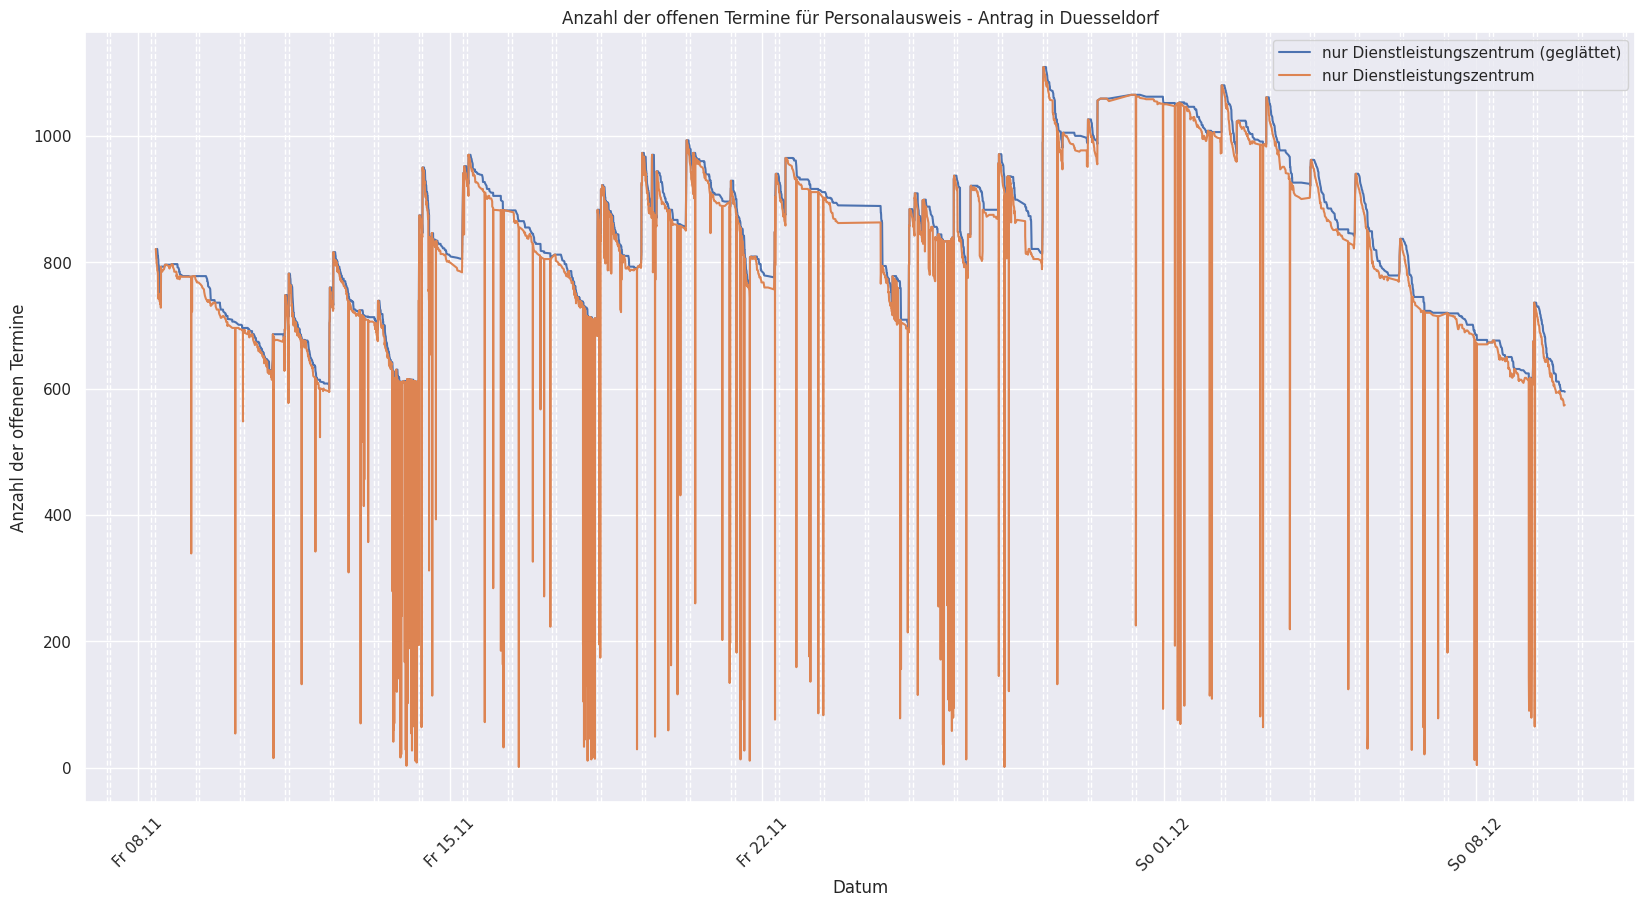

In [10]:
# duesseldorf personalausweis antrag nur DZ geglättet
fig, ax = plt.subplots(figsize=(20, 10))

dues_nur_dz["smoothed"] = dues_nur_dz["count"].rolling(window=15).max()
y = "smoothed"

sns.lineplot(
    data=dues_nur_dz,
    x="timestamp",
    y=y,
    ax=ax,
    label="nur Dienstleistungszentrum (geglättet)",
)
sns.lineplot(
    data=dues_nur_dz,
    x="timestamp",
    y="count",
    ax=ax,
    label="nur Dienstleistungszentrum",
)

ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1, 8, 15, 22]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
ax.xaxis.grid(True, which="minor", linestyle="--")

ax.set_title(
    "Anzahl der offenen Termine für Personalausweis - Antrag in Duesseldorf"
)

ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl der offenen Termine")

# plt.savefig(
#     f"bachelorarbeit/bilder/offene_termine_personalausweis_duesseldorf_nur_dz.png",
# )
plt.show()

In [11]:
from datetime import datetime, timedelta
import pandas as pd


def calc_capacity_per_office(office: str, start_date):

    if not isinstance(start_date, datetime):
        raise ValueError("start_date must be a datetime object")

    # check for nat and raise error
    if pd.isna(start_date):
        return 462 * 3

    max_days_per_office = {
        "Benrath": 12,
        "Bilk": 14,
        "Dienstleistungszentrum": 21,
        "Eller": 11,
        "Garath": 7,
        "Gerresheim": 10,
        "Kaiserswerth": 9,
        "Rath": 14,
        "Unterbach": 8,
        "Wersten/Holthausen": 13,
    }

    if office not in max_days_per_office:
        raise ValueError(f"Unknown office: {office}")
    # 5 minutes per slot
    # 12 slots per hour

    # Monday and Tuesday
    # 7:30 - 16:00 -> 8.5 hours * 12 slots = 102 slots

    # Wednesday and Friday
    # 7:30 - 13:00 -> 5.5 hours * 12 slots = 66 slots

    # Thursday
    # 7:30 - 18:00 -> 10.5 hours * 12 slots = 126 slots

    # -> 102 + 102 + 66 + 126 + 66 = 462 slots per week
    # -> 462 * 3 = 1386 slots per 3 weeks per office
    # -> 1386 * 10 = 13860 slots per 3 weeks for all offices

    # abweichende öffnungszeiten in Unterbach
    # Mo 9:30 - 13:00, 13:30 - 16:00 -> 3.5 + 2.5 = 6 hours * 12 slots = 72 slots
    # Do 9:30 - 13:00, 14:00 - 18:00 -> 3.5 + 4 = 7.5 hours * 12 slots = 90 slots

    # max_slots_per_day = {
    #     "Monday": 102,
    #     "Tuesday": 102,
    #     "Wednesday": 66,
    #     "Thursday": 126,
    #     "Friday": 66,
    #     "Saturday": 0,
    #     "Sunday": 0,
    # }
    max_slots_per_day_over_a_week = {
        "Montag": 102,
        "Dienstag": 102,
        "Mittwoch": 66,
        "Donnerstag": 126,
        "Freitag": 66,
        "Samstag": 0,
        "Sonntag": 0,
    }

    # unterbach_max_slots_per_day = {"Monday": 72, "Thursday": 90}
    unterbach_max_slots_per_day = {"Montag": 72, "Donnerstag": 90}

    total_count = 0
    for day in range(max_days_per_office[office]):
        day_name = start_date + timedelta(days=day)
        if (
            office == "Unterbach"
            and day_name.strftime("%A") in unterbach_max_slots_per_day
        ):
            count_that_day = unterbach_max_slots_per_day[day_name.strftime("%A")]
        else:
            count_that_day = max_slots_per_day_over_a_week[day_name.strftime("%A")]
        total_count += count_that_day

    return total_count

In [12]:
calc_capacity_per_office("Benrath", pd.NaT)

1386

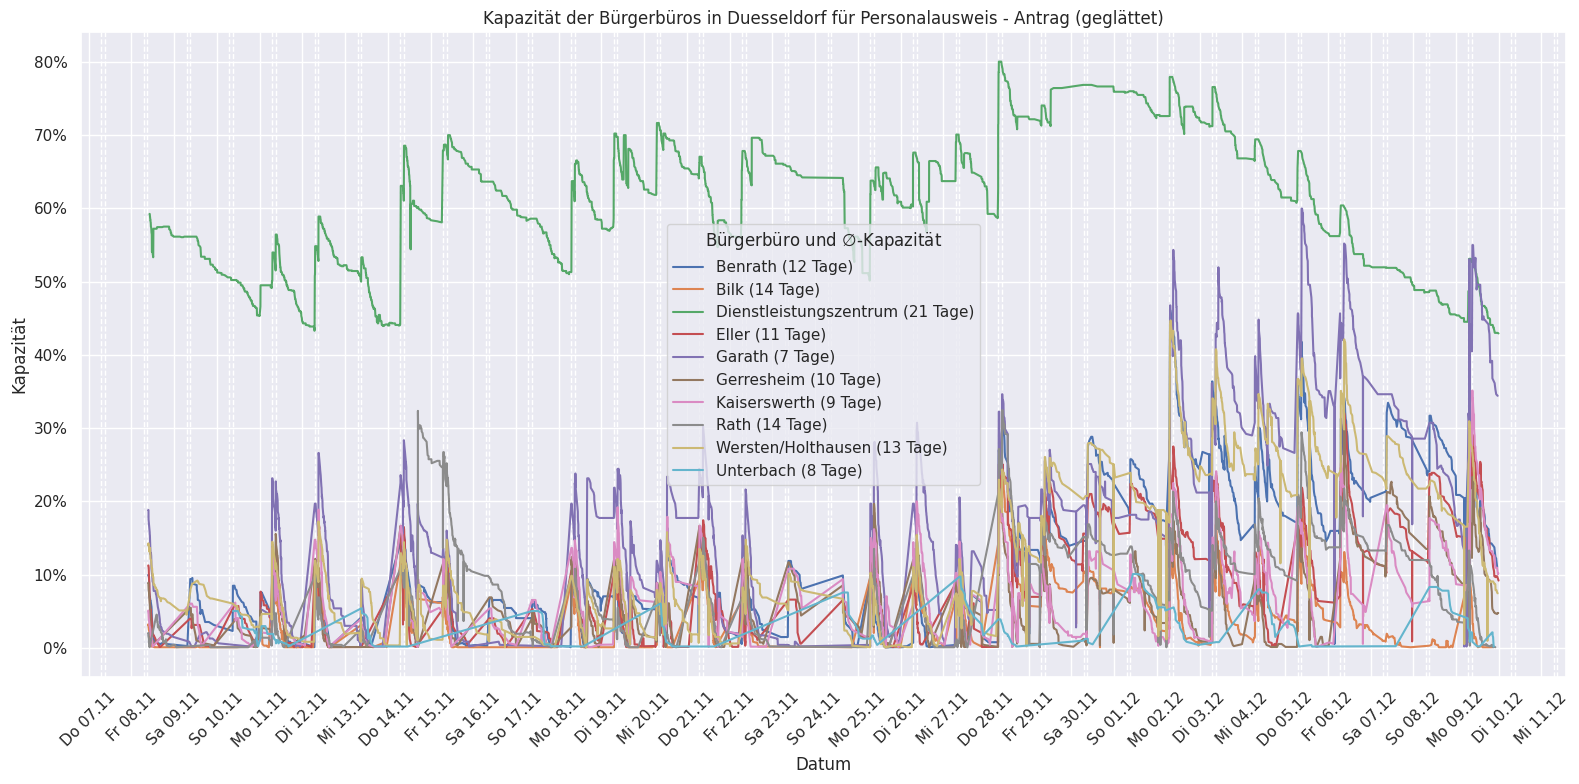

In [13]:
offices = [None]
offices = [
    "Benrath",
    "Bilk",
    "Dienstleistungszentrum",
    "Eller",
    "Garath",
    "Gerresheim",
    "Kaiserswerth",
    "Rath",
    "Wersten/Holthausen",
    "Unterbach",
]

fig, ax = plt.subplots(figsize=(16, 8))

max_days_per_office = {
        "Benrath": 12,
        "Bilk": 14,
        "Dienstleistungszentrum": 21,
        "Eller": 11,
        "Garath": 7,
        "Gerresheim": 10,
        "Kaiserswerth": 9,
        "Rath": 14,
        "Unterbach": 8,
        "Wersten/Holthausen": 13,
    }

for office in offices:
    count = tools.create_time_series(
        duesseldorf,
        city="Duesseldorf",
        concern="Personalausweis - Antrag",
        office=office,
    )
    count["total_capacity"] = count["timestamp"].apply(
        lambda x: calc_capacity_per_office(office, x)
    )
    count["capacity"] = count["count"] / count["total_capacity"]
    
    count["smooth_count"] = count["count"].rolling(window=15).max()
    count["smooth_capacity"] = count["smooth_count"] / count["total_capacity"]

    sns.lineplot(
        data=count,
        x="timestamp",
        y="smooth_capacity" if office == "Dienstleistungszentrum" else "capacity",
        ax=ax,
        label=f"{office} ({max_days_per_office[office]} Tage)"
    )

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# # set y axis as percentage
# vals = ax.get_yticks()
# ax.set_yticklabels(["{:.0%}".format(x) for x in vals])

ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
ax.xaxis.grid(True, which="minor", linestyle="--")

ax.set_title(
    "Kapazität der Bürgerbüros in Duesseldorf für Personalausweis - Antrag (geglättet)"
)
ax.set_xlabel("Datum")
ax.set_ylabel("Kapazität")

ax.legend(
    title="Bürgerbüro und $\\varnothing$-Kapazität",
)

plt.tight_layout()

plt.savefig(
    f"bachelorarbeit/bilder/kapazitaet_duesseldorf_alle_buergerbueros.png",
)
plt.show()

In [14]:
count_df = pd.DataFrame()

for office in offices:
    count_office = tools.create_time_series(
        duesseldorf,
        city="Duesseldorf",
        concern="Personalausweis - Antrag",
        office=office,
    )

    count_office["office"] = office

    count_office["total_capacity"] = count_office["timestamp"].apply(
        lambda x: calc_capacity_per_office(office, x)
    )
    count_office["capacity"] = count_office["count"] / count_office["total_capacity"]

    count_office["days_until_slot"] = (
        duesseldorf[duesseldorf["office"] == office]["days_until_slot"]
        .max()
        .round(0)
        .astype(int)
    )

    count_office["smooth_count"] = count_office["count"].rolling(window=15).max()
    count_office["smooth_capacity"] = count_office["smooth_count"] / count_office[
        "total_capacity"
    ]

    count_df = pd.concat([count_df, count_office])

# print(count_df)
mean_capacity_per_office = (
    count_df.groupby(["office"]).mean().sort_values("capacity", ascending=False)
)


mean_capacity_per_office.loc["Alle"] = mean_capacity_per_office.agg(
    {
        "days_until_slot": "mean",
        "total_capacity": "sum",
        "count": "sum",
        "capacity": "mean",
    }
)
mean_capacity_per_office["mean_total_capacity"] = mean_capacity_per_office["total_capacity"].map(
    "{:.0f}".format
)

mean_capacity_per_office["days"] = mean_capacity_per_office["days_until_slot"].map(
    "{:.0f}".format
)

mean_capacity_per_office["mean_count"] = mean_capacity_per_office["count"].map(
    "{:.0f}".format
)
mean_capacity_per_office["smooth_count"] = mean_capacity_per_office["smooth_count"].map(
    "{:.0f}".format
)

mean_capacity_per_office["capacity"] = mean_capacity_per_office["capacity"].map(
    "{:.1%}".format
)


mean_capacity_per_office[["days", "mean_total_capacity", "mean_count", "capacity"]]

/tmp/ipykernel_28296/2278101170.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_capacity_per_office.loc["Alle"] = mean_capacity_per_office.agg(


,days,mean_total_capacity,mean_count,capacity
office,,,,
Dienstleistungszentrum,21,1386,769,55.5%
Garath,7,462,92,19.9%
Wersten/Holthausen,13,857,117,13.6%
Benrath,12,803,105,13.0%
Eller,11,749,76,10.2%
Rath,14,924,91,9.8%
Kaiserswerth,9,621,56,8.9%
Gerresheim,10,676,53,7.9%
Bilk,14,924,60,6.4%


In [15]:
# add column with the hour of the Taken timestamp

duesseldorf.loc[:, "taken_hour"] = duesseldorf.loc[:, "taken"].dt.hour

duesseldorf.loc[:, "available_hour"] = duesseldorf.loc[:, "available"].dt.hour

# set column to wether the column office is Dienstleistungszentrum or not
duesseldorf.loc[:, "is_dz"] = duesseldorf.loc[:, "office"] == "Dienstleistungszentrum"

d_sorted = duesseldorf.sort_values("count_availabilities", ascending=False)
d_sorted

,Unnamed: 0,s_id,office,city,timeslot,concern,a_id,available,taken,count_availabilities,weekday,hour,delta,time_until_slot,total_delta,days_open,days_until_slot,taken_hour,available_hour,is_dz
292671,299996,6494,Dienstleistungszentrum,Duesseldorf,2024-11-28 11:15:00,Personalausweis - Antrag,299997,2024-11-14 08:36:00,2024-11-14 12:34:00,219,Thursday,11,0 days 03:58:00,13 days 22:41:00,19 days 15:24:00,19.64,13.95,12.00,8,True
292672,219730,6494,Dienstleistungszentrum,Duesseldorf,2024-11-28 11:15:00,Personalausweis - Antrag,219731,2024-11-13 21:37:00,2024-11-13 21:42:00,219,Thursday,11,0 days 00:05:00,14 days 13:33:00,19 days 15:24:00,19.64,14.56,21.00,21,True
292673,717514,6494,Dienstleistungszentrum,Duesseldorf,2024-11-28 11:15:00,Personalausweis - Antrag,717515,2024-11-26 06:24:00,2024-11-26 06:29:00,219,Thursday,11,0 days 00:05:00,2 days 04:46:00,19 days 15:24:00,19.64,2.20,6.00,6,True
292674,273840,6494,Dienstleistungszentrum,Duesseldorf,2024-11-28 11:15:00,Personalausweis - Antrag,273841,2024-11-14 05:18:00,2024-11-14 05:21:00,219,Thursday,11,0 days 00:03:00,14 days 05:54:00,19 days 15:24:00,19.64,14.25,5.00,5,True
292675,204759,6494,Dienstleistungszentrum,Duesseldorf,2024-11-28 11:15:00,Personalausweis - Antrag,204760,2024-11-13 18:40:00,2024-11-13 19:02:00,219,Thursday,11,0 days 00:22:00,14 days 16:13:00,19 days 15:24:00,19.64,14.68,19.00,18,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230681,5315,5316,Benrath,Duesseldorf,2024-11-08 10:00:00,Personalausweis - Antrag,5316,2024-11-08 09:27:00,2024-11-08 09:57:00,1,Friday,10,0 days 00:30:00,0 days 00:03:00,0 days 00:30:00,0.02,0.00,9.00,9,False
230680,5314,5315,Benrath,Duesseldorf,2024-11-08 09:55:00,Personalausweis - Antrag,5315,2024-11-08 09:27:00,2024-11-08 09:52:00,1,Friday,9,0 days 00:25:00,0 days 00:03:00,0 days 00:25:00,0.02,0.00,9.00,9,False
230679,5313,5314,Benrath,Duesseldorf,2024-11-08 09:50:00,Personalausweis - Antrag,5314,2024-11-08 09:27:00,2024-11-08 09:46:00,1,Friday,9,0 days 00:19:00,0 days 00:04:00,0 days 00:19:00,0.01,0.00,9.00,9,False
230678,5312,5313,Benrath,Duesseldorf,2024-11-08 09:45:00,Personalausweis - Antrag,5313,2024-11-08 09:27:00,2024-11-08 09:42:00,1,Friday,9,0 days 00:15:00,0 days 00:03:00,0 days 00:15:00,0.01,0.00,9.00,9,False


In [16]:
duesseldorf_only_first_available = duesseldorf.groupby("s_id").first("available")

duesseldorf_only_first_available

,Unnamed: 0,a_id,count_availabilities,hour,days_open,days_until_slot,taken_hour,available_hour,is_dz
s_id,,,,,,,,,
5311,5310,5311,1,9,0.00,0.00,9.00,9,False
5312,5311,5312,1,9,0.01,0.00,9.00,9,False
5313,5312,5313,1,9,0.01,0.00,9.00,9,False
5314,5313,5314,1,9,0.01,0.00,9.00,9,False
5315,5314,5315,1,9,0.02,0.00,9.00,9,False
...,...,...,...,...,...,...,...,...,...
119175,998644,998645,1,16,0.02,2.82,20.00,20,False
119176,998645,998646,1,16,0.04,2.80,21.00,20,False
119177,998646,998647,1,16,0.01,2.83,20.00,20,False


In [17]:
duesseldorf_only_last_taken = duesseldorf.groupby("s_id").last("taken")

duesseldorf_only_last_taken

,Unnamed: 0,a_id,count_availabilities,hour,days_open,days_until_slot,taken_hour,available_hour,is_dz
s_id,,,,,,,,,
5311,5310,5311,1,9,0.00,0.00,9.00,9,False
5312,5311,5312,1,9,0.01,0.00,9.00,9,False
5313,5312,5313,1,9,0.01,0.00,9.00,9,False
5314,5313,5314,1,9,0.01,0.00,9.00,9,False
5315,5314,5315,1,9,0.02,0.00,9.00,9,False
...,...,...,...,...,...,...,...,...,...
119175,998644,998645,1,16,0.02,2.82,20.00,20,False
119176,998645,998646,1,16,0.04,2.80,21.00,20,False
119177,998646,998647,1,16,0.01,2.83,20.00,20,False


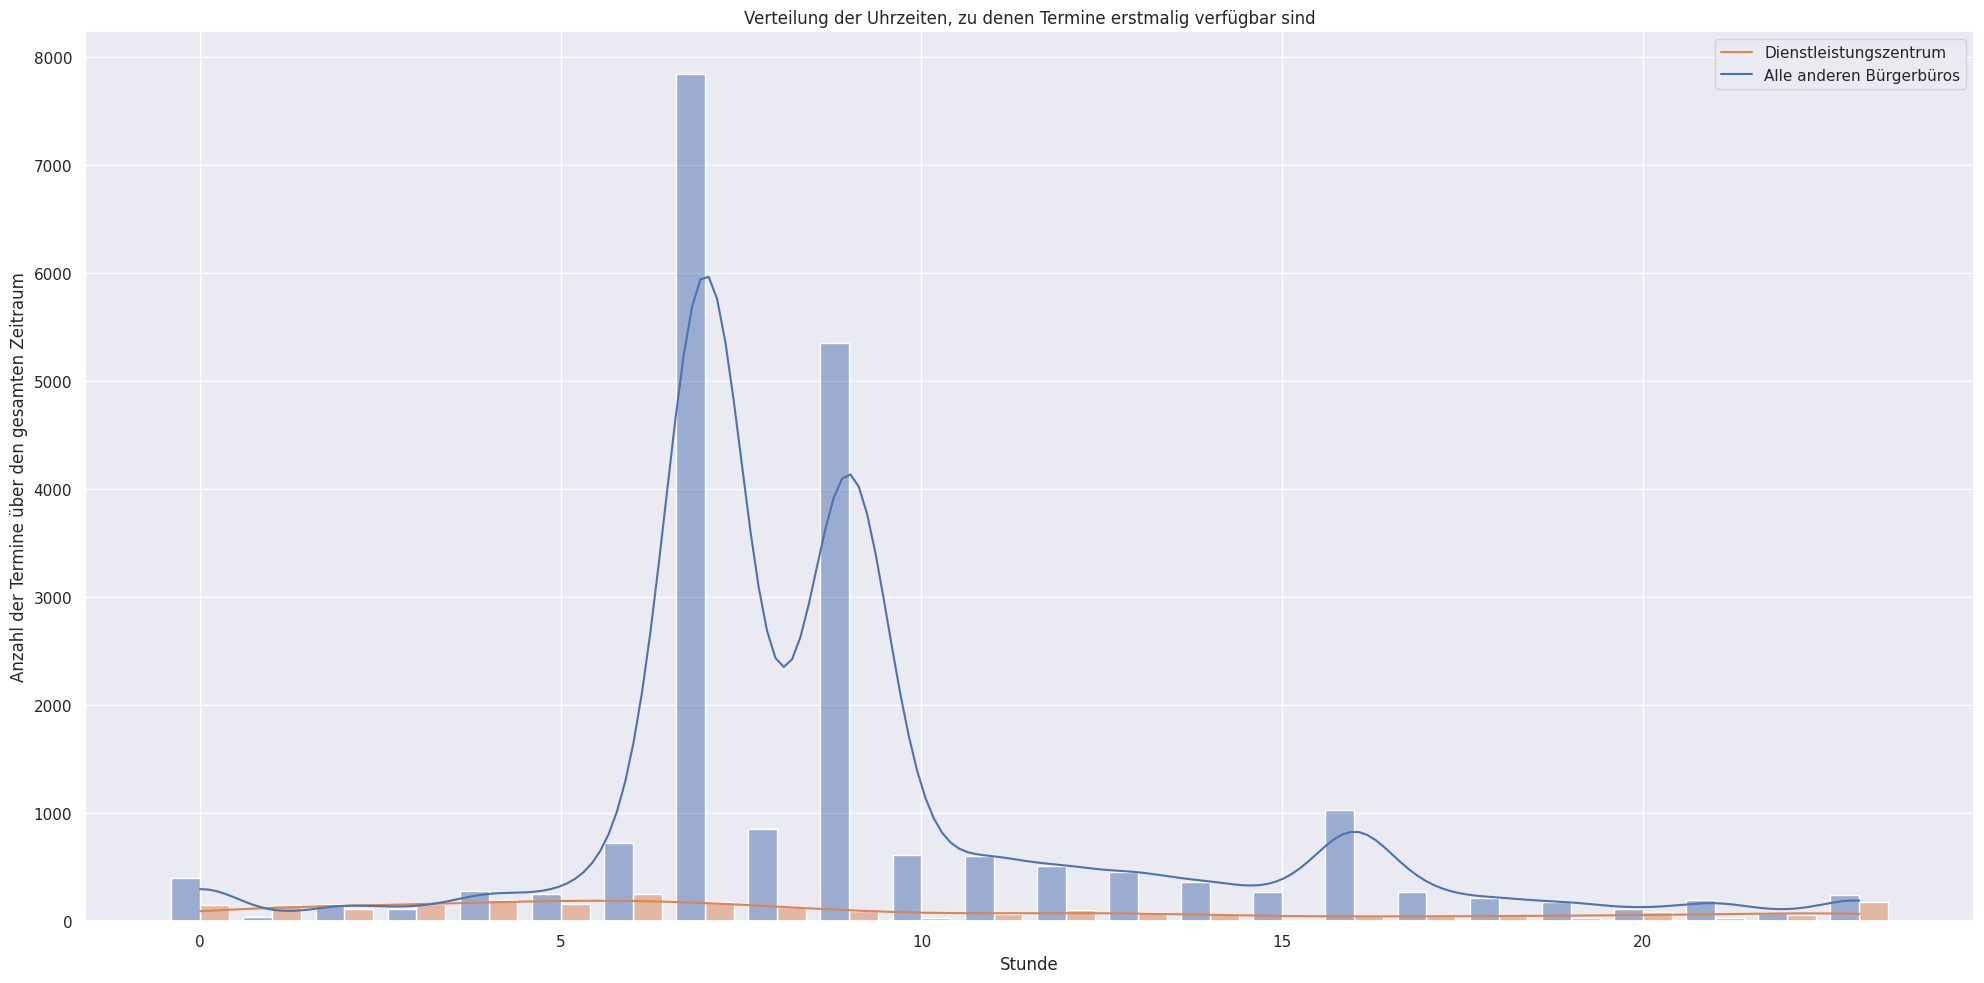

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.histplot(
    data=duesseldorf_only_first_available,
    x="available_hour",
    hue="is_dz",
    multiple="dodge",
    ax=ax,
    discrete=True,
    kde=True,
    shrink=0.8,
)

# ax.xaxis.set_major_locator(plt.MultipleLocator(1))
# ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.set_title("Verteilung der Uhrzeiten, zu denen Termine erstmalig verfügbar sind")
ax.set_xlabel("Stunde")
ax.set_ylabel("Anzahl der Termine über den gesamten Zeitraum")

ax.legend(
    labels=["Dienstleistungszentrum", "Alle anderen Bürgerbüros"],

)


plt.tight_layout()

plt.savefig(
    f"bachelorarbeit/bilder/verteilung_erstmalige_verfuegbarkeit.png",
)

plt.show()

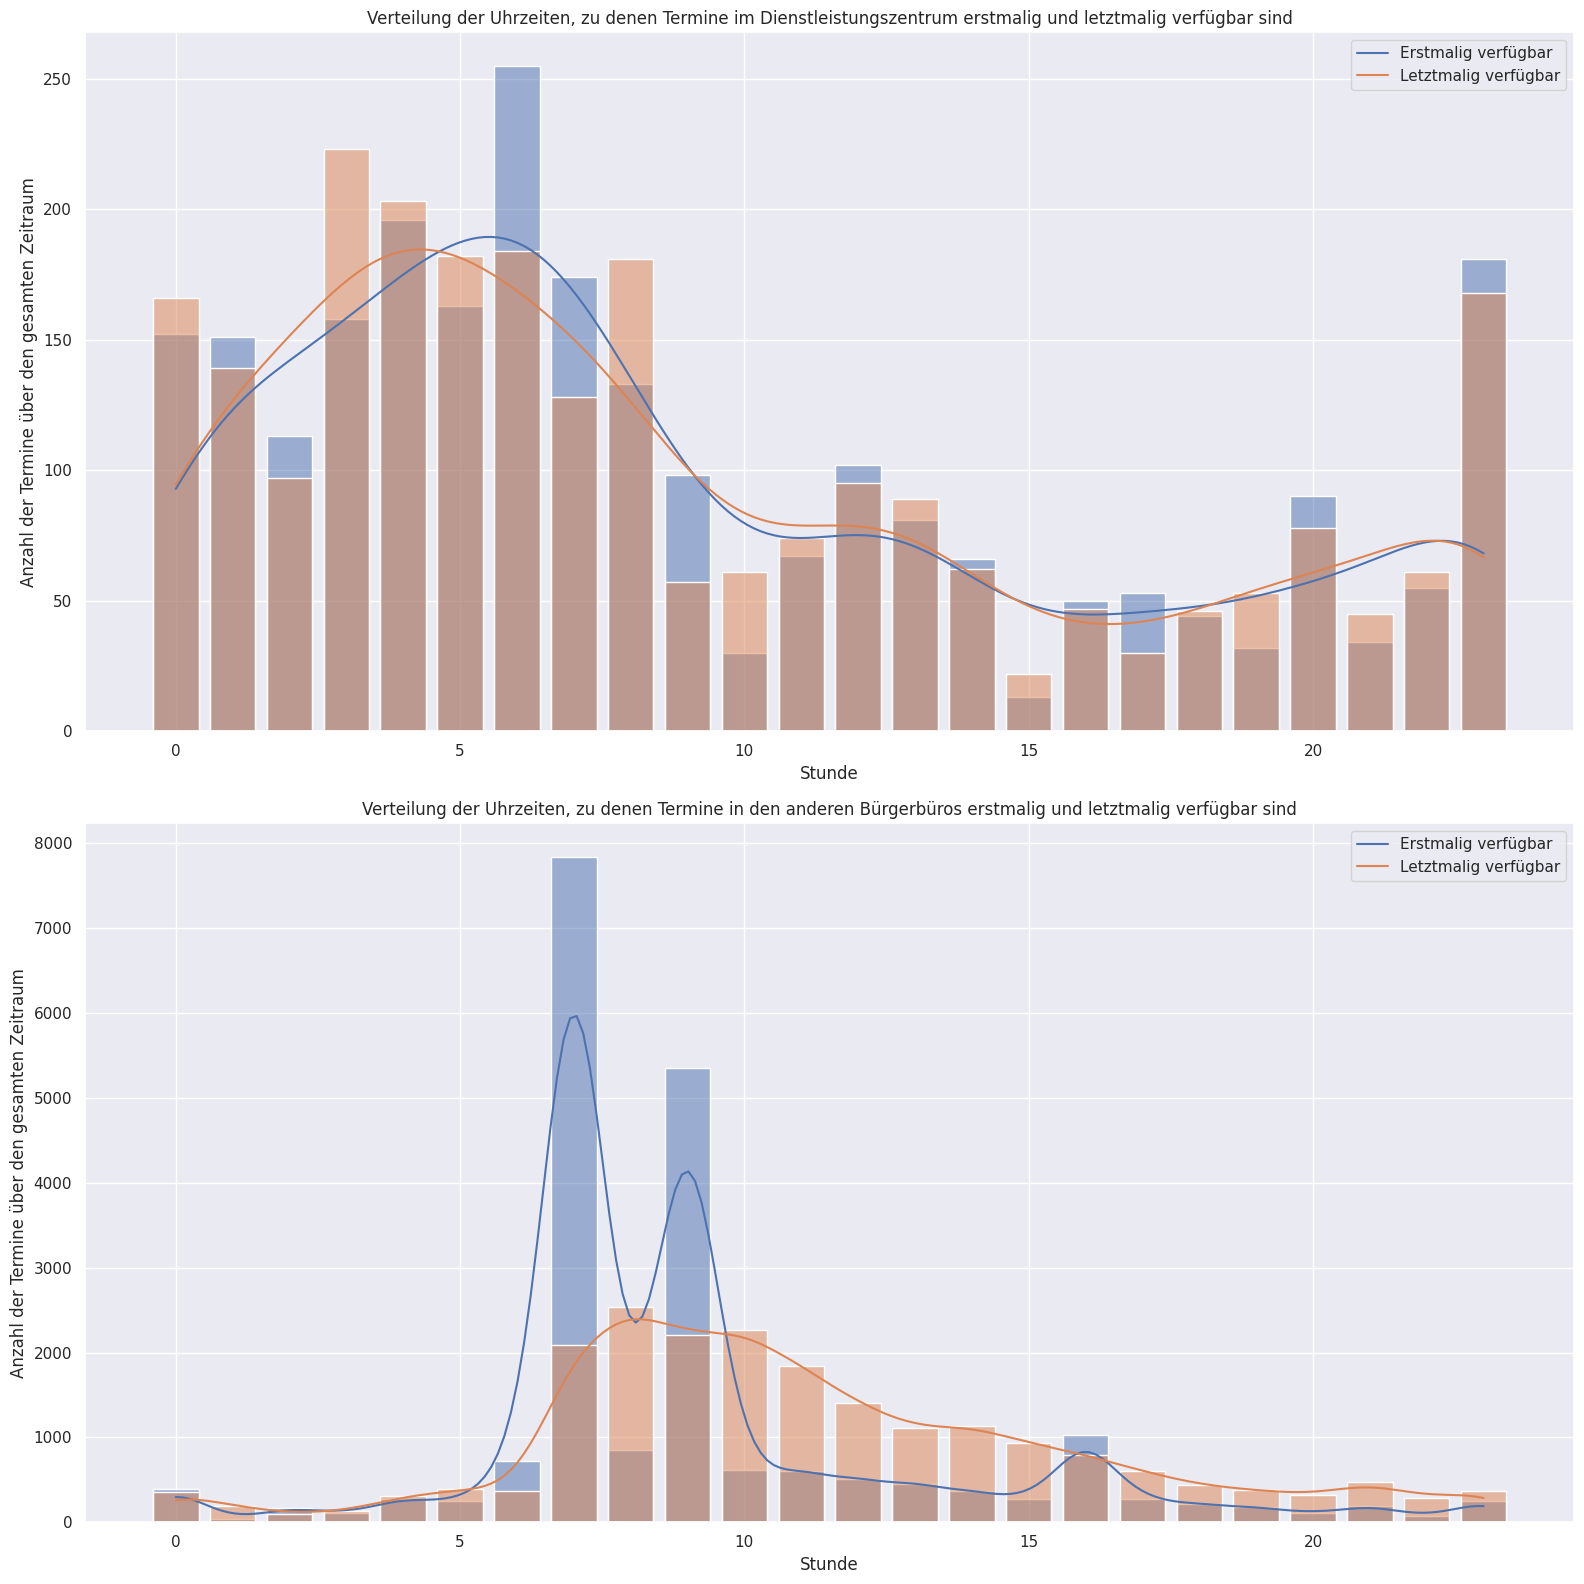

In [19]:
fig, ax = plt.subplots(figsize=(16, 16), nrows=2, ncols=1)

sns.histplot(
    data=duesseldorf_only_first_available[
        duesseldorf_only_first_available["is_dz"] == True
    ],
    x="available_hour",
    # hue="is_dz",
    multiple="dodge",
    ax=ax[0],
    discrete=True,
    kde=True,
    shrink=0.8,
)

sns.histplot(
    data=duesseldorf_only_last_taken[
        duesseldorf_only_last_taken["is_dz"] == True
    ],
    x="taken_hour",
    # hue="is_dz",
    multiple="dodge",
    ax=ax[0],
    discrete=True,
    kde=True,
    shrink=0.8,
)


sns.histplot(
    data=duesseldorf_only_first_available[
        duesseldorf_only_first_available["is_dz"] == False
    ],
    x="available_hour",
    # hue="is_dz",
    multiple="dodge",
    ax=ax[1],
    discrete=True,
    kde=True,
    shrink=0.8,
)

sns.histplot(
    data=duesseldorf_only_last_taken[
        duesseldorf_only_last_taken["is_dz"] == False
    ],
    x="taken_hour",
    # hue="is_dz",
    multiple="dodge",
    ax=ax[1],
    discrete=True,
    kde=True,
    shrink=0.8,
)

ax[0].set_title("Verteilung der Uhrzeiten, zu denen Termine im Dienstleistungszentrum erstmalig und letztmalig verfügbar sind")
ax[0].set_xlabel("Stunde")
ax[0].set_ylabel("Anzahl der Termine über den gesamten Zeitraum")

ax[0].legend(
    labels=["Erstmalig verfügbar", "Letztmalig verfügbar"],
)

ax[1].set_title("Verteilung der Uhrzeiten, zu denen Termine in den anderen Bürgerbüros erstmalig und letztmalig verfügbar sind")
ax[1].set_xlabel("Stunde")
ax[1].set_ylabel("Anzahl der Termine über den gesamten Zeitraum")

ax[1].legend(
    labels=["Erstmalig verfügbar", "Letztmalig verfügbar"],
)

plt.tight_layout()

plt.savefig(
    f"bachelorarbeit/bilder/verteilung_erstmalige_letztmalige_verfuegbarkeit.png",
)

plt.show()

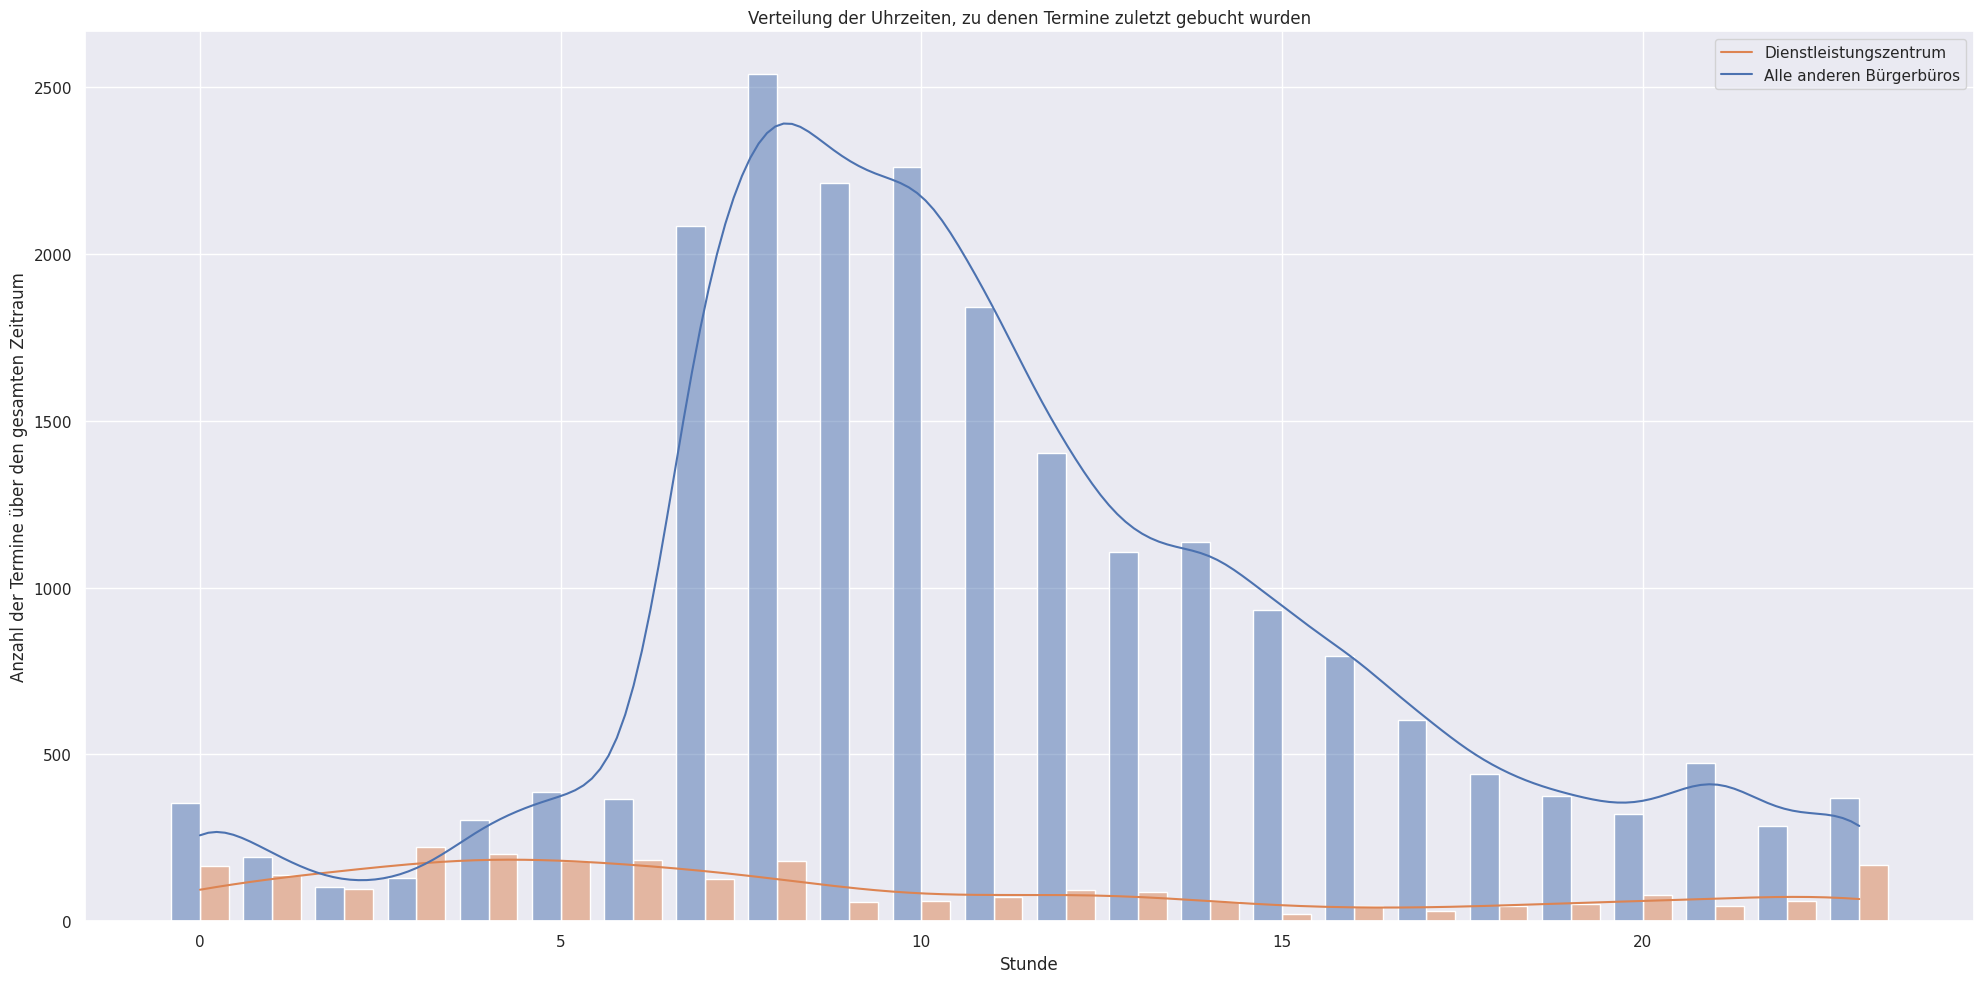

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.histplot(
    data=duesseldorf_only_last_taken,
    x="taken_hour",
    hue="is_dz",
    multiple="dodge",
    ax=ax,
    discrete=True,
    kde=True,
    shrink=0.8,
)

ax.set_title("Verteilung der Uhrzeiten, zu denen Termine zuletzt gebucht wurden")
ax.set_xlabel("Stunde")
ax.set_ylabel("Anzahl der Termine über den gesamten Zeitraum")

ax.legend(
    labels=["Dienstleistungszentrum", "Alle anderen Bürgerbüros"],

)

plt.tight_layout()

plt.savefig(
    f"bachelorarbeit/bilder/verteilung_letzte_buchung.png",
)

plt.show()

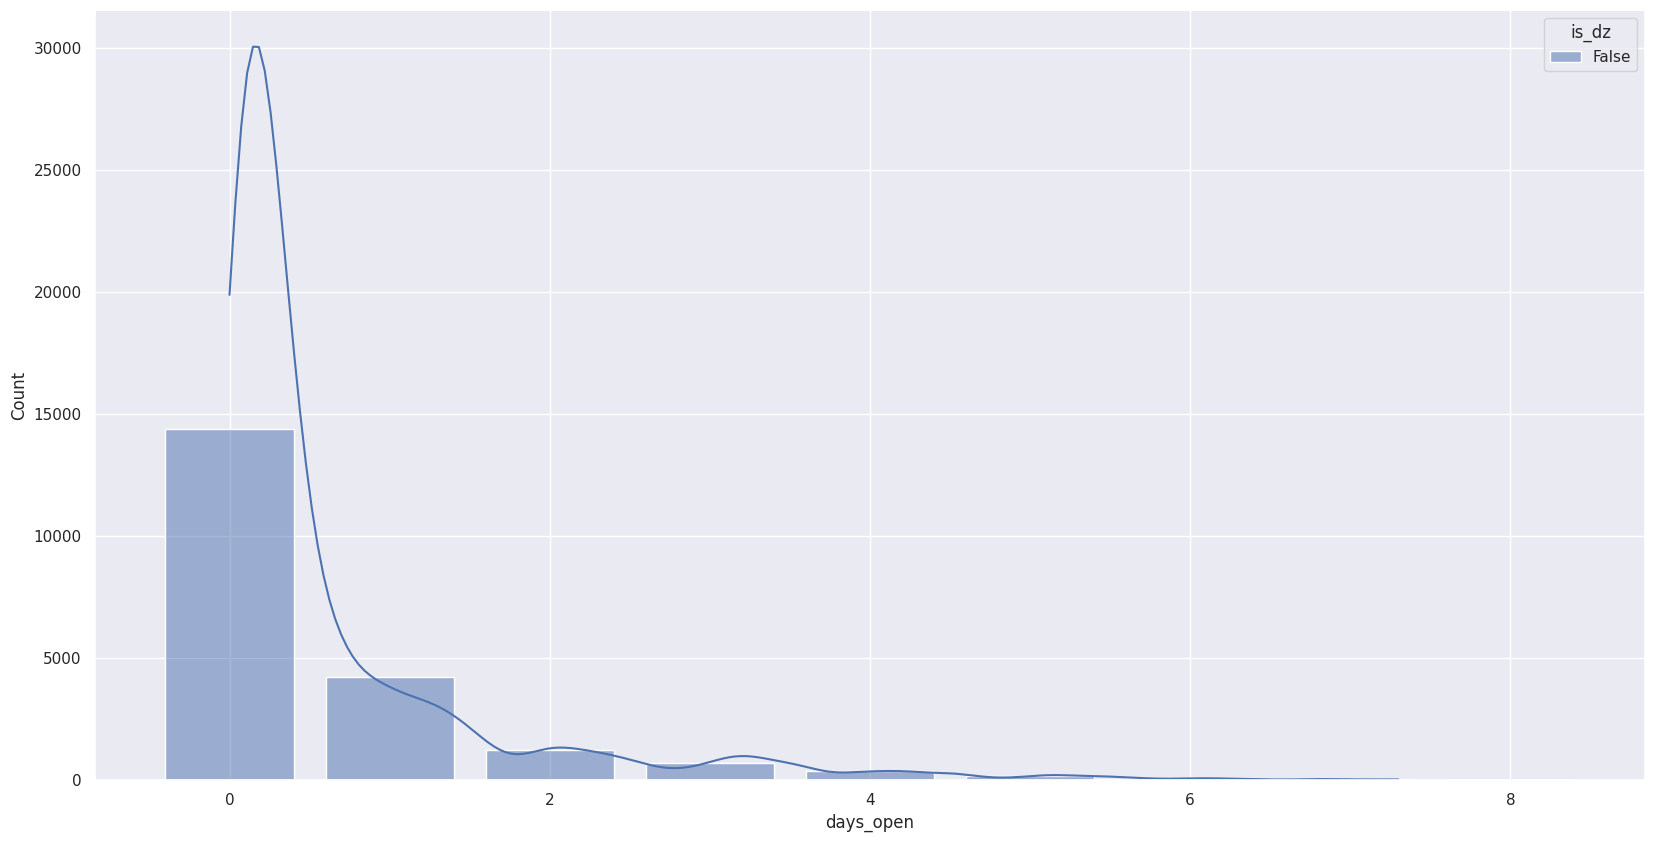

In [21]:
# duesseldorf_only_last_taken["days_until_slot"]

fig, ax = plt.subplots(figsize=(20, 10))

sns.histplot(
    data=duesseldorf_only_last_taken[duesseldorf_only_last_taken["is_dz"] == False],
    x="days_open",
    hue="is_dz",
    multiple="dodge",
    ax=ax,
    discrete=True,
    kde=True,
    shrink=0.8,
)

plt.show()

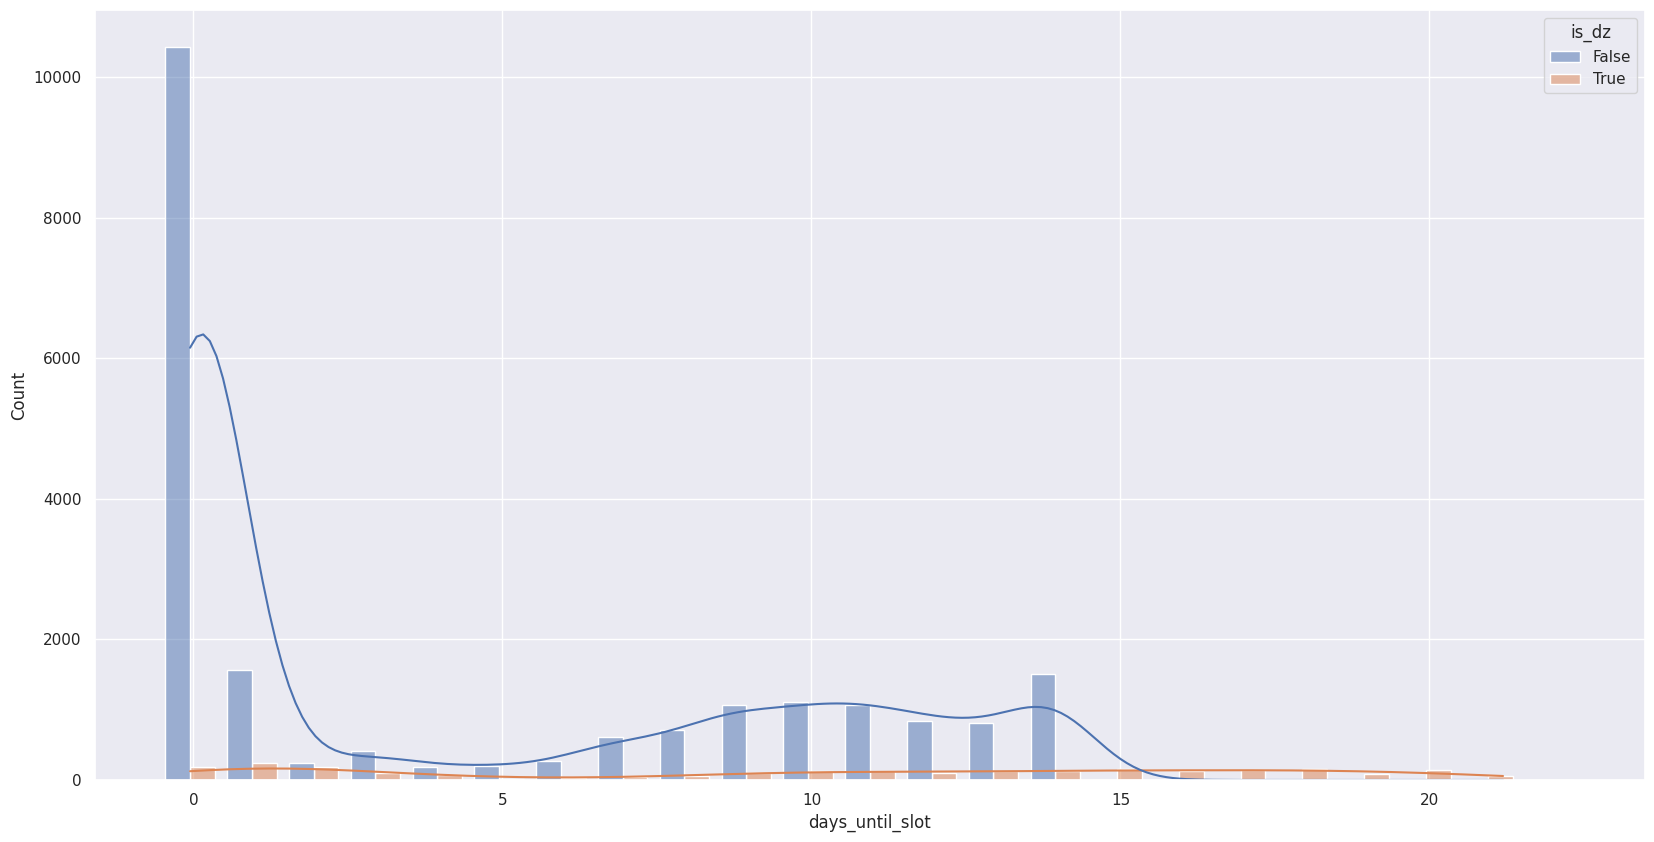

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.histplot(
    data=duesseldorf_only_first_available,
    x="days_until_slot",
    hue="is_dz",
    multiple="dodge",
    ax=ax,
    discrete=True,
    kde=True,
    shrink=0.8,
)

plt.show()
# ax.xaxis.set_major_locator(plt.MultipleLocator(1))

In [23]:
# dues_nur_dz = viztool.create_time_series(
#     df,
#     city="Duesseldorf",
#     concern="Personalausweis - Antrag",
#     office="Dienstleistungszentrum",
# )
# dues_nur_dz.describe()

In [24]:
# # rolling max
# dues_nur_dz["rolling_max"] = dues_nur_dz["count"].rolling(window=15).max()

# # dues_nur_dz
# dues_nur_dz["diff"] = dues_nur_dz["rolling_max"].diff()

# # remove all positive values
# dues_nur_dz[dues_nur_dz["diff"] > 0] = 0
# # remove outliers
# dues_nur_dz[dues_nur_dz["diff"] < -100] = 0

# dues_nur_dz["diff"] = dues_nur_dz["diff"].abs()

# # remove nan
# dues_nur_dz.dropna(inplace=True)

